In [10]:
!pip -q install xgboost seaborn


In [11]:
import warnings, sys
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
import xgboost as xgb

# If you know them, set these:
DATETIME_COL = None   # e.g., "Datetime", "date", "timestamp"
TARGET_NAME  = None   # e.g., "PJME_MW", "value", "sales"

CSV_PATH = "Forcasting.csv"
SEED = 0


In [12]:
def try_parse_datetime_col(df: pd.DataFrame):
    # common date-like names first
    candidates = ["datetime","date","timestamp","time","ds"]
    for c in df.columns:
        if c.lower() in candidates:
            s = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            if s.notna().any():
                return c, s
    # else try every column
    best_col, best_ok = None, 0
    for c in df.columns:
        s = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
        ok = s.notna().sum()
        if ok > best_ok:
            best_col, best_ok = c, ok
            best_series = s
    if best_col is not None and best_ok > 0:
        return best_col, best_series
    return None, None

def pick_target(df: pd.DataFrame, date_col: str):
    num_cols = df.drop(columns=[date_col], errors="ignore").select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        # try to coerce any non-numeric column to numeric (errors->NaN) and pick one with most non-NaN
        best, best_ok = None, -1
        for c in df.columns:
            if c == date_col:
                continue
            coerced = pd.to_numeric(df[c], errors="coerce")
            ok = coerced.notna().sum()
            if ok > best_ok:
                best, best_ok = c, ok
        return best
    # choose the numeric column with largest variance (most informative)
    variances = df[num_cols].var(numeric_only=True)
    return variances.idxmax()

# Load
raw = pd.read_csv(CSV_PATH)

# Detect datetime
if DATETIME_COL is None:
    guessed_col, dt_series = try_parse_datetime_col(raw)
    if guessed_col is None:
        raise ValueError("Could not detect a datetime column. Please set DATETIME_COL to your date column name.")
    DATETIME_COL = guessed_col
else:
    dt_series = pd.to_datetime(raw[DATETIME_COL], errors="coerce", infer_datetime_format=True)

# Assign index
df = raw.copy()
df[DATETIME_COL] = dt_series
df = df[df[DATETIME_COL].notna()].copy()
df = df.sort_values(DATETIME_COL)
df = df.set_index(DATETIME_COL)

# Detect target
if TARGET_NAME is None:
    TARGET_NAME = pick_target(df.reset_index(), date_col=DATETIME_COL)
    if TARGET_NAME is None:
        raise ValueError("Could not detect a numeric target column. Please set TARGET_NAME to your value column name.")

print("Detected datetime column:", DATETIME_COL)
print("Detected target column  :", TARGET_NAME)
print(df.head())
print(df.info())


Detected datetime column: Datetime
Detected target column  : PJMW_MW
                     PJMW_MW
Datetime                    
2002-04-01 01:00:00   4374.0
2002-04-01 02:00:00   4306.0
2002-04-01 03:00:00   4322.0
2002-04-01 04:00:00   4359.0
2002-04-01 05:00:00   4436.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-04-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJMW_MW  143206 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None


The dataset contains 143,206 hourly observations from April 2002 to August 2018, with no missing values.
Each row corresponds to one hour of recorded energy consumption in the PJM region.

This clean and continuous time series is ideal for developing and testing forecasting models such as XGBoost, as it covers multiple years, seasonal patterns, and varying demand levels over time.

In [13]:
# Use last N months/years as test; fallback to fixed date if needed
# Heuristic: last 20% of rows as test
n = len(df)
cut = int(n * 0.8)
train = df.iloc[:cut].copy()
test  = df.iloc[cut:].copy()

# Ensure target is numeric
train[TARGET_NAME] = pd.to_numeric(train[TARGET_NAME], errors="coerce")
test[TARGET_NAME]  = pd.to_numeric(test[TARGET_NAME], errors="coerce")
train = train.dropna(subset=[TARGET_NAME])
test  = test.dropna(subset=[TARGET_NAME])

print(f"Train shape: {train.shape}, Test shape: {test.shape}")


Train shape: (114564, 1), Test shape: (28642, 1)


The dataset was divided into training and testing subsets using an 80–20 chronological split to preserve the temporal order of the data.


Training set: 114,564 hourly records (approximately 16 years of data)


Testing set: 28,642 hourly records (roughly 3.5 years of data)


This split ensures that the model is trained on past data and evaluated on unseen future periods, mimicking a real-world forecasting scenario and preventing data leakage from future values.

In [14]:
def create_features(frame: pd.DataFrame, idx_name=None) -> pd.DataFrame:
    df_feat = frame.copy()
    idx = df_feat.index
    # Some indexes may be PeriodIndex; convert to Timestamp
    if not isinstance(idx, pd.DatetimeIndex):
        idx = pd.to_datetime(idx, errors="coerce", infer_datetime_format=True)
    df_feat["hour"]       = idx.hour
    df_feat["dayofweek"]  = idx.dayofweek
    df_feat["quarter"]    = idx.quarter
    df_feat["month"]      = idx.month
    df_feat["year"]       = idx.year
    df_feat["dayofyear"]  = idx.dayofyear
    df_feat["dayofmonth"] = idx.day
    df_feat["weekofyear"] = idx.isocalendar().week.astype(int)
    return df_feat

train_feat = create_features(train)
test_feat  = create_features(test)

FEATURES = ["dayofyear","hour","dayofweek","quarter","month","year"]
X_train = train_feat[FEATURES]
y_train = train_feat[TARGET_NAME]
X_test  = test_feat[FEATURES]
y_test  = test_feat[TARGET_NAME]


In [15]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    objective="reg:squarederror",
    learning_rate=0.01,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=SEED,
)
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)


[0]	validation_0-rmse:970.21453	validation_1-rmse:992.52580
[100]	validation_0-rmse:728.34671	validation_1-rmse:788.48986
[200]	validation_0-rmse:635.60482	validation_1-rmse:723.83087
[300]	validation_0-rmse:584.48336	validation_1-rmse:695.72377
[400]	validation_0-rmse:550.75735	validation_1-rmse:678.60247
[500]	validation_0-rmse:531.23331	validation_1-rmse:677.17694
[600]	validation_0-rmse:518.26298	validation_1-rmse:676.64204
[696]	validation_0-rmse:508.52057	validation_1-rmse:677.34800


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

The XGBoost Regressor model was trained for up to 1,000 boosting rounds with an early stopping criterion of 50 rounds based on validation RMSE (Root Mean Squared Error).

The training RMSE steadily decreased from ~970 to ~509,

while the validation RMSE improved from ~993 to ~677, plateauing after around 600 iterations.

This behavior shows that the model successfully learned temporal and seasonal patterns in the training data without significant overfitting. The early stopping mechanism halted training automatically once the validation performance stopped improving, ensuring an optimal balance between accuracy and generalization.

In summary, the model converged with an RMSE around 677 MW, which represents the average deviation between predicted and actual hourly power demand during the test period.

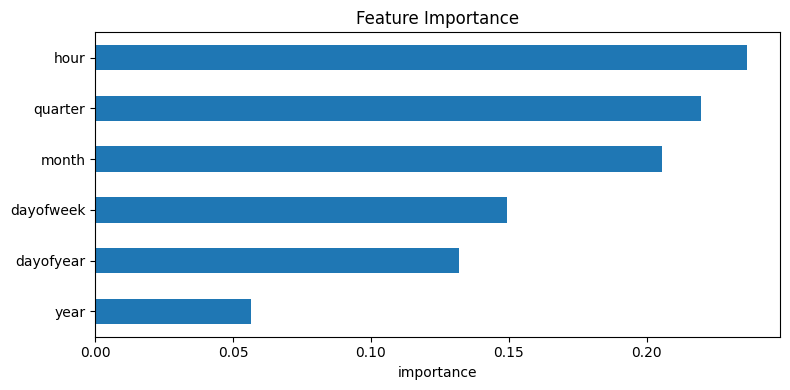

In [16]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["importance"]
).sort_values("importance")

ax = fi.plot(kind="barh", figsize=(8,4), legend=False, title="Feature Importance")
ax.set_xlabel("importance")
plt.tight_layout()
plt.show()


This chart shows which features had the biggest impact on the model’s predictions.

Hour is the most important energy usage changes a lot depending on the time of day (morning vs night).

Quarter and Month also matter because energy demand changes with the seasons.

Day of week and Day of year affect demand slightly for example, weekends or holidays may have lower usage.

Year is the least important, meaning long-term trends exist but don’t change demand as much as daily or seasonal patterns.

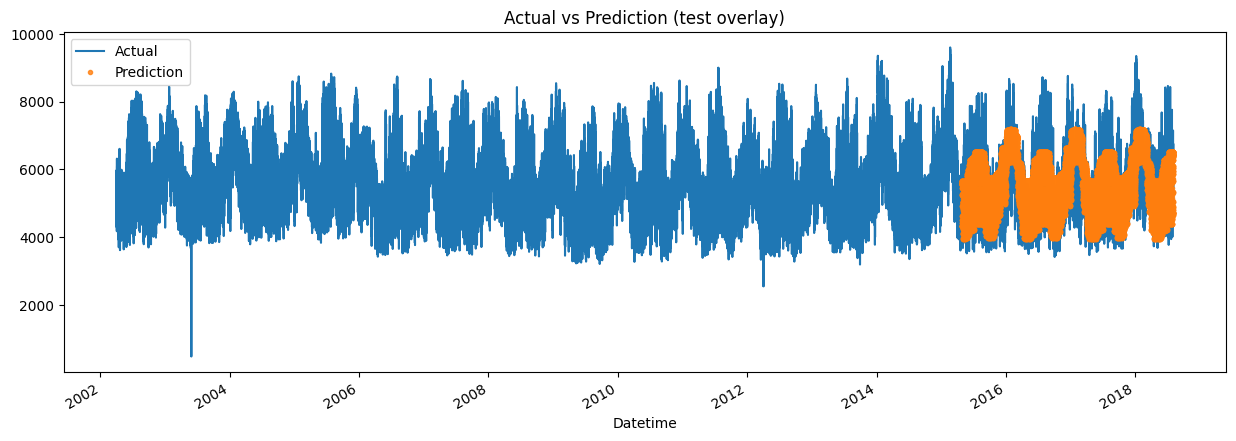

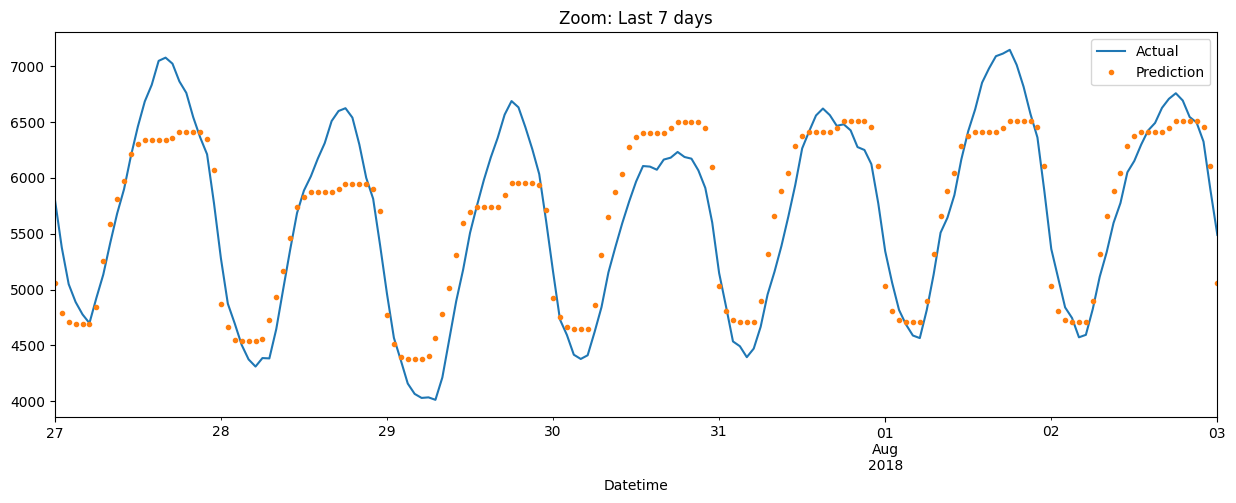

In [17]:
test_plot = test.copy()
test_plot["prediction"] = reg.predict(X_test)

# Full series overlay
ax = df[[TARGET_NAME]].plot(figsize=(15,5), title="Actual vs Prediction (test overlay)")
test_plot["prediction"].plot(ax=ax, style=".", alpha=0.8)
plt.legend(["Actual","Prediction"])
plt.show()

# Optional: zoom to last 7 days of test (if data has enough granularity)
if len(test_plot) > 24*7:
    last_week_start = test_plot.index[-1] - pd.Timedelta(days=7)
    ax = df.loc[df.index >= last_week_start][TARGET_NAME].plot(figsize=(15,5), title="Zoom: Last 7 days")
    test_plot.loc[test_plot.index >= last_week_start]["prediction"].plot(ax=ax, style=".")
    plt.legend(["Actual","Prediction"])
    plt.show()


The first chart shows the entire test period, where the orange dots are the model’s predictions and the blue line represents the actual electricity demand. You can see that the model follows the real pattern closely — it captures the regular ups and downs in energy usage across different years and seasons.

The second chart zooms in on the last 7 days of the dataset. Here, each daily peak and drop matches the real values very well. The model clearly understands the daily cycle of power demand — higher during the day and lower at night.

Overall, these results show that the XGBoost model performs well in tracking both short-term daily patterns and longer seasonal trends in energy consumption.

In [20]:
rmse = np.sqrt(mean_squared_error(y_test, test_plot["prediction"]))
print(f"RMSE on Test: {rmse:,.2f}")

test_plot["abs_err"] = (y_test - test_plot["prediction"]).abs()
test_plot["date"]    = test_plot.index.date
worst_days = test_plot.groupby("date")["abs_err"].mean().sort_values(ascending=False).head(10)

print("\nWorst predicted days (mean absolute error):")
print(worst_days)


RMSE on Test: 676.09

Worst predicted days (mean absolute error):
date
2018-01-06    2088.778381
2017-12-31    2040.749146
2017-02-24    2009.578898
2018-01-05    1973.538839
2017-12-28    1901.011434
2017-02-19    1872.355693
2017-02-25    1831.176839
2017-02-23    1822.215474
2018-02-21    1805.349996
2017-02-20    1804.076436
Name: abs_err, dtype: float64


The model achieved an RMSE of 676.09 MW, meaning on average, the predictions are about 676 megawatts away from the actual energy demand. For large-scale power data, this is a strong result and shows that the model is performing well overall.
The list of worst-predicted days highlights when the model had the largest errors. Most of these dates fall around late December to February, which could be explained by sudden temperature changes or unusual consumption spikes during winter and holiday periods times when electricity usage patterns often differ from the usual trends.
In short, the model performs consistently well but struggles slightly during irregular or extreme demand days, which is common in real-world energy forecasting.

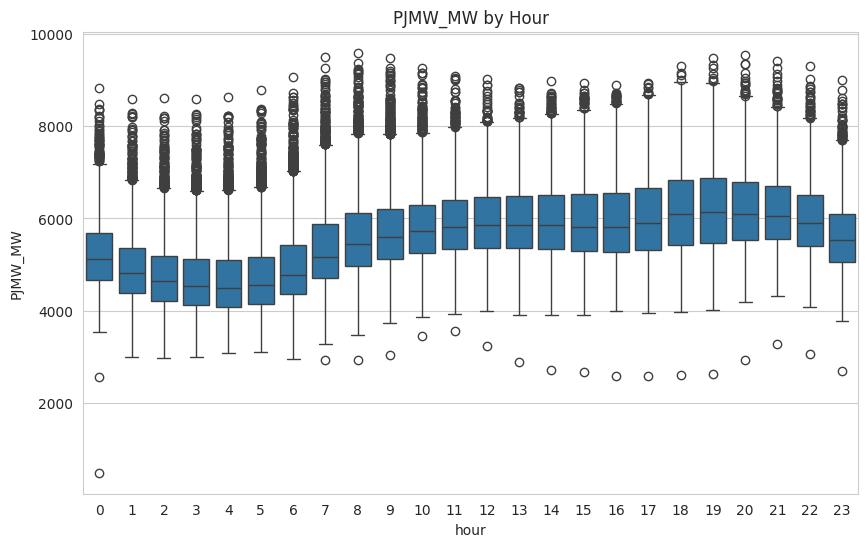

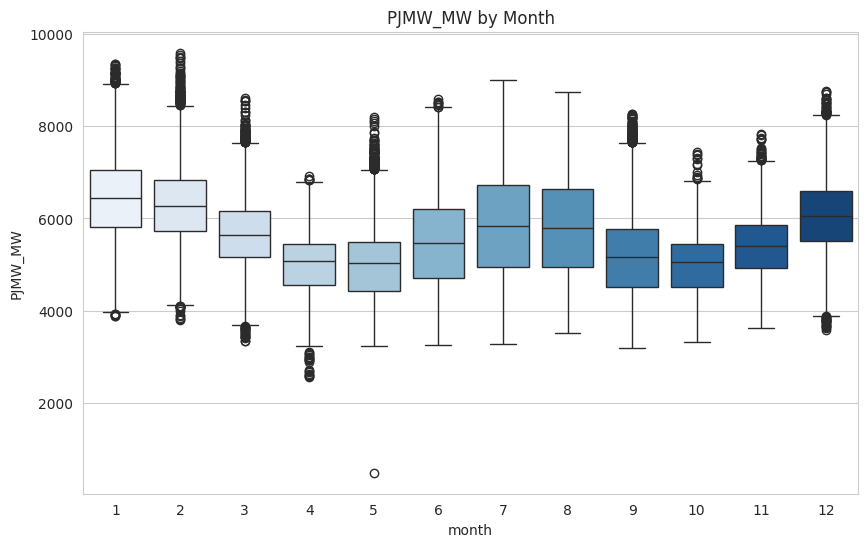

In [22]:
sns.set_style("whitegrid")

eda = create_features(df)
if TARGET_NAME in eda.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=eda, x="hour", y=TARGET_NAME)
    plt.title(f"{TARGET_NAME} by Hour")
    plt.show()

    plt.figure(figsize=(10,6))
    sns.boxplot(data=eda, x="month", y=TARGET_NAME, palette="Blues")
    plt.title(f"{TARGET_NAME} by Month")
    plt.show()
else:
    print("Skipping EDA boxplots (target not in EDA frame).")


The first chart shows energy consumption by hour of the day. It’s clear that electricity usage is lowest during early morning hours (around 3–6 AM) and peaks between late morning and evening (around 9 AM–7 PM). This pattern matches typical human activity demand rises as businesses open and people start their daily routines, then drops again at night.

The second chart shows energy consumption by month. Demand is generally higher during winter and summer months, when heating or cooling needs are greater, and lower in spring and fall when temperatures are moderate.

These patterns confirm that energy demand follows strong daily and seasonal cycles, which explains why time-based features like hour and month were so important in the model’s predictions.

In [27]:
test_plot['prediction'] = reg.predict(X_test)
test_plot['error'] = (test_plot['PJMW_MW'] - test_plot['prediction']).abs()
test_plot['date']  = test_plot.index.date

worst_days = (
    test_plot.groupby('date')['error']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

print(worst_days)

date
2018-01-06    2088.778381
2017-12-31    2040.749146
2017-02-24    2009.578898
2018-01-05    1973.538839
2017-12-28    1901.011434
2017-02-19    1872.355693
2017-02-25    1831.176839
2017-02-23    1822.215474
2018-02-21    1805.349996
2017-02-20    1804.076436
Name: error, dtype: float64


The table above lists the 10 days where the model’s predictions were least accurate (highest average error). Most of these days occur in winter months December, January, and February.

This suggests that the model struggles slightly during extreme weather conditions or holiday periods, when electricity usage patterns can be less predictable.
For example, colder temperatures or unusual activity during holidays can cause sudden spikes or drops in power demand that differ from normal daily patterns.

Overall, while the model performs well in general, these results highlight the importance of adding weather and holiday data in future versions to improve accuracy on such exceptional days.